In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

from ImageD11 import grain, unitcell, refinegrains

%matplotlib widget

In [2]:
def qpv(vectors, labels=None):
    
    vectors = vectors / np.linalg.norm(vectors, axis=1)[:, np.newaxis]
    
    # Extract components
    X, Y, Z = np.zeros(len(vectors)), np.zeros(len(vectors)), np.zeros(len(vectors))  # Origins at (0,0,0)
    U, V, W = vectors[:, 0], vectors[:, 1], vectors[:, 2]  # Vector components

    # Create figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

    # Plot quiver
    ax.quiver(X, Y, Z, U, V, W, color='b', length=1, normalize=False)
    
    if labels is not None:
        for i, label in enumerate(labels):
            ax.text(U[i], V[i], W[i], label, color='r', fontsize=12, weight='bold')
    
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_aspect('equal')

    return fig, ax

# Reference frames

# Real space

## Fractional real space - [uvw]
### Basis vectors
$(a, b, c)$
### Units
unitless?
### Vector example
$\underline{v_{uvw}} = u\vec{a} + v\vec{b} + w\vec{c}$
### Usage
- Describe a point in a unitcell - e.g. where atoms are in a CIF file
- Describe a direction in a unitcell w.r.t the real lattice vectors.

## orthogonal/Cartesian real space
### Basis vectors
$(x, y, z)$
### Units
Angstroms
### Vector example
$\underline{v_{xyz}} = i\vec{x} + j\vec{y} + k\vec{z}$
### Usage
???

# Reciprocal space

## Fractional reciprocal space - (hkl)
### Basis vectors
$(a^*, b^*, c^*)$
### Units
unitless?
### Vector example
$\underline{G_{hkl}} = h\vec{a^*} + k\vec{b^*} + l\vec{c^*}$
### Usage
- describe a crystallographic set of planes - the vector represents the normal to the planes in this space

## grain-fixed orthogonal/Cartesian reciprocal space
$\underline{G_{c}} = B \underline{G_{hkl}}$

<!-- $S$ is normally identity, but:
## sample-fixed orthogonal/Cartesian reciprocal space
$\underline{G_{s}} = U B \underline{G_{hkl}}$

## rotating orthogonal/Cartesian reciprocal space
$\underline{G_{\gamma}} = S U B \underline{G_{hkl}}$ -->

## lab-fixed orthogonal/Cartesian reciprocal space
$\underline{G_{l}} = \Gamma S U B \underline{G_{hkl}}$

# Transformation matrices

## $U$ - orientation matrix
Transforms from grain-fixed orthogonal/Cartesian reciprocal space to sample-fixed orthogonal/Cartesian reciprocal space

## $B$ - reciprocal space orthogonalization matrix
Transforms from fractional reciprocal space to orthogonal/Cartesian reciprocal space

## $A$ - reciprocal space fractionalization matrix
Transforms from orthogonal/Cartesian reciprocal space to fractional reciprocal space - depending on how you define it w.r.t $B$!

## $O$ - real space orthogonalization matrix
Transforms from fractional real space to orthogonal/Cartesian real space

## $F$ - real space fractionalization matrix
Transforms from orthogonal/Cartesian real space to fractional real space

## $G_{ij}$ - real space fractional metric tensor
Transforms from fractional real space to fractional reciprocal space

## $G^{ij} = G_{ij}^{-1}$ - reciprocal space fractional metric tensor
Transforms from fractional reciprocal space to fractional real space

# Orthogonal/Cartesian spaces
It turns out that if you define $O$ and $F$ in terms of $B$, the orthogonal real and orthogonal reciprocal spaces perfectly agree!!!  
More below.

# Testing
## Import a grain

In [3]:
# some weird P-1 cell
# ICSD 131
# use standardized parameters

lpars = (6.441, 9.354, 10.011, 116.849998, 90.550003, 99.279999)
spacegroup = 2
hms = 'P-1'

In [4]:
ucell = unitcell.unitcell(lpars, spacegroup)

In [5]:
# U = np.eye(3)
U = R.from_euler('XYZ', [0, 90, 0], degrees=True).as_matrix()
U

array([[ 2.22044605e-16,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00,  0.00000000e+00,  2.22044605e-16]])

In [6]:
B = ucell.B
B

array([[0.15800827, 0.02263424, 0.01052786],
       [0.        , 0.11982413, 0.05056759],
       [0.        , 0.        , 0.09989012]])

In [7]:
UB = U.dot(B)

In [8]:
UBI = np.linalg.inv(UB)

In [9]:
g = grain.grain(UBI)

In [10]:
g.mt

array([[ 41.486481  ,  -9.71573094,  -0.6189656 ],
       [ -9.71573094,  87.497316  , -42.29439983],
       [ -0.6189656 , -42.29439983, 100.220121  ]])

## Validate against VESTA

import a CIF into VESTA for ICSD 131  
go to Utilities -> Standardization to transform into standardized  
then go to Edit -> Edit Data -> Phase to adjust the orientation  
This layer      |        Global coordinate system  
we want (h k l ) 1 0 0 || [u v w] 1 0 0  
this is a* || x axis  
then [u v w] 0 0 1 || (h k l) 0 0 1  
then you can look along a, b, c, a*, b* and c*  
to confirm equality  

VESTA plots in orthogonal real space - xyz

In [11]:
a_real_frac = np.array([1.0, 0., 0])
b_real_frac = np.array([0., 1.0, 0])
c_real_frac = np.array([0., 0., 1.0])

astar_recip_frac = np.array([1.0, 0., 0])
bstar_recip_frac = np.array([0., 1.0, 0])
cstar_recip_frac = np.array([0., 0.,1.0])

In [12]:
def real_frac_to_real_orth(vec_uvw, O):
    vec_xyz = O @ vec_uvw
    return vec_xyz

def real_orth_to_real_frac(vec_xyz, F):
    vec_uvw = F @ vec_xyz
    return vec_uvw

def real_frac_to_recip_frac(v_uvw, mt):
    """Convert a vector from the real basis (a, b, c) 
    to the reciprocal basis (a*, b*, c*)."""
    v_hkl = mt @ v_uvw
    return v_hkl

def recip_frac_to_real_frac(v_hkl, rmt):
    """Convert a vector from the reciprocal basis (a*, b*, c*)
    to the real basis (a, b, c)."""
    v_uvw = rmt @ v_hkl
    return v_uvw

def recip_frac_to_recip_orth(v_hkl, B):
    v_xyz = B @ v_hkl
    return v_xyz

def recip_orth_to_recip_frac(v_xyz, B):
    v_hkl = np.linalg.inv(B) @ v_xyz
    return v_hkl

def recip_orth_to_recip_lab(v_xyz, U):
    v_xlylzl = U @ v_xyz
    return v_xlylzl

def recip_lab_to_recip_orth(v_xlylzl, U):
    v_xyz = np.linalg.inv(U) @ v_xlylzl
    return v_xyz

# cross transforms

def recip_frac_to_recip_lab(v_hkl, UB):
    v_xlylzl = UB @ v_hkl
    return v_xlylzl

def recip_lab_to_recip_frac(v_xlylzl, UBI):
    # g-vectors are in reciprocal cartesian co-ordinates in the lab frame
    v_hkl = UBI @ v_xlylzl
    return v_hkl

In [13]:
# also to look along certain orientations in (a, b, c)
# go to Objects -> Orientation
# projection vector - which direct space vector vector points towards you?
# upward vector - which reciprocal space vector goes upwards on the screen?

In [14]:
# use mode project along [uvw]
# e.g if we want to look down [111] with [010] up:
# proj_vector [uvw] = [111] as desired
# upward_vector (hkl) = direct_to_reciprocal([010])
upward_vector_uvw = [0., 1.,0.]
upward_vector_hkl = real_frac_to_recip_frac(upward_vector_uvw, g.mt)
upward_vector_hkl

array([ -9.71573094,  87.497316  , -42.29439983])

In [15]:
# or with mode project along the normal to (h k l):
# if we want to look down [111] with [010] up:
# proj_vector (hkl) = direct_to_reciprocal([111])
# upward_vector [uvw] = [010] as desired
proj_vector_uvw = [1., 1.,1.]
proj_vector_hkl = real_frac_to_recip_frac(proj_vector_uvw, g.mt)
proj_vector_hkl

array([31.15178446, 35.48718524, 57.30675557])

# Definition of $O$ and $F$
As per https://dials.diamond.ac.uk/documentation/conventions.html

We define $F \equiv B^T$, therefore $O \equiv (B^T)^{-1}$

In [16]:
g.F = g.B.T
g.O = np.linalg.inv(g.B.T)

assert np.allclose(g.B.T @ g.O, np.eye(3))

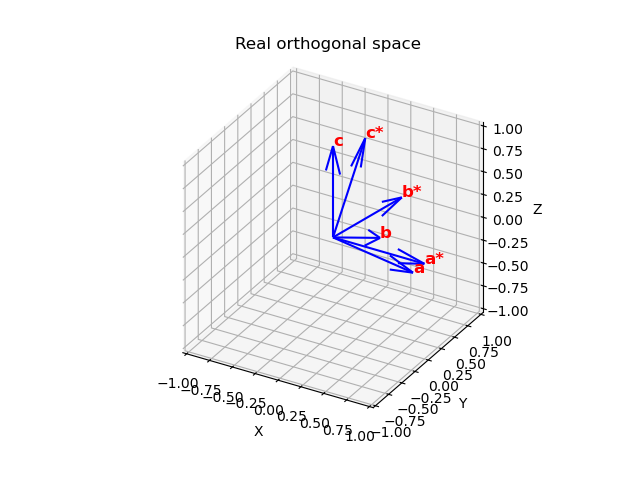

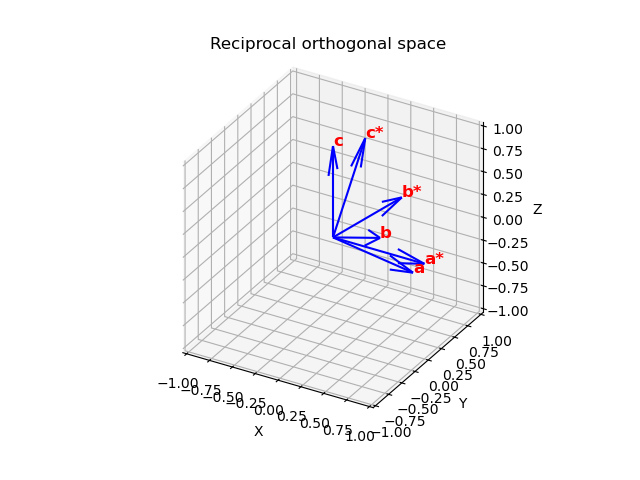

In [17]:
a_real_orth = real_frac_to_real_orth(a_real_frac, g.O)
b_real_orth = real_frac_to_real_orth(b_real_frac, g.O)
c_real_orth = real_frac_to_real_orth(c_real_frac, g.O)

astar_real_frac = recip_frac_to_real_frac(astar_recip_frac, g.rmt)
bstar_real_frac = recip_frac_to_real_frac(bstar_recip_frac, g.rmt)
cstar_real_frac = recip_frac_to_real_frac(cstar_recip_frac, g.rmt)

astar_real_orth = real_frac_to_real_orth(astar_real_frac, g.O)
bstar_real_orth = real_frac_to_real_orth(bstar_real_frac, g.O)
cstar_real_orth = real_frac_to_real_orth(cstar_real_frac, g.O)

# is the reciprocal frac <-> orth convention maintained?
# astar along x
# c along z
assert np.arccos(astar_real_orth @ np.array([1., 0., 0])/np.linalg.norm(astar_real_orth)) == 0
assert np.arccos(c_real_orth @ np.array([0., 0., 1])/np.linalg.norm(c_real_orth)) == 0

a_recip_frac = real_frac_to_recip_frac(a_real_frac, g.mt)
b_recip_frac = real_frac_to_recip_frac(b_real_frac, g.mt)
c_recip_frac = real_frac_to_recip_frac(c_real_frac, g.mt)

a_recip_orth = recip_frac_to_recip_orth(a_recip_frac, g.B)
b_recip_orth = recip_frac_to_recip_orth(b_recip_frac, g.B)
c_recip_orth = recip_frac_to_recip_orth(c_recip_frac, g.B)

astar_recip_orth = recip_frac_to_recip_orth(astar_recip_frac, g.B)
bstar_recip_orth = recip_frac_to_recip_orth(bstar_recip_frac, g.B)
cstar_recip_orth = recip_frac_to_recip_orth(cstar_recip_frac, g.B)

assert np.arccos(astar_recip_orth @ np.array([1., 0., 0])/np.linalg.norm(astar_recip_orth)) == 0
assert np.arccos(c_recip_orth @ np.array([0., 0., 1])/np.linalg.norm(c_recip_orth)) == 0

allvecs = np.vstack((a_real_orth, b_real_orth, c_real_orth, astar_real_orth, bstar_real_orth, cstar_real_orth))
f, a = qpv(allvecs, labels=['a', 'b', 'c', 'a*', 'b*', 'c*'])
a.set(title='Real orthogonal space')
plt.show()

allvecs2 = np.vstack((a_recip_orth, b_recip_orth, c_recip_orth, astar_recip_orth, bstar_recip_orth, cstar_recip_orth))
f, a = qpv(allvecs2, labels=['a', 'b', 'c', 'a*', 'b*', 'c*'])
a.set(title='Reciprocal orthogonal space')
plt.show()

assert np.allclose(allvecs, allvecs2)

In [39]:
# if the orthogonal spaces agree
# B @ g.mt @ F should equal identity
# O @  g.rmt @ B-1  should equal identity

assert np.allclose( g.B @ g.mt @ g.F, np.eye(3))
assert np.allclose( g.O @ g.rmt @ np.linalg.inv(g.B), np.eye(3))

In [41]:
# g.O is the (a, b, c) in real orthogonal space (crystal frame) as columns
print(g.O)
assert np.allclose(g.O, np.column_stack((a_real_orth, b_real_orth, c_real_orth)))
print(a_real_orth)
print(b_real_orth)
print(c_real_orth)

[[ 6.32878259  0.          0.        ]
 [-1.19547863  8.34556424  0.        ]
 [-0.06182855 -4.22479271 10.011     ]]


[ 6.32878259 -1.19547863 -0.06182855]
[ 0.          8.34556424 -4.22479271]
[ 0.     0.    10.011]


In [43]:
# g.B is the (a*, b*, c*) in real orthogonal space (crystal frame) as columns
print(g.B)
assert np.allclose(g.B, np.column_stack((astar_real_orth, bstar_real_orth, cstar_real_orth)))
print(astar_real_orth)
print(bstar_real_orth)
print(cstar_real_orth)

[[0.15800827 0.02263424 0.01052786]
 [0.         0.11982413 0.05056759]
 [0.         0.         0.09989012]]
[1.58008272e-01 9.36224997e-18 2.97960574e-18]
[2.26342411e-02 1.19824133e-01 2.80082974e-17]
[0.01052786 0.05056759 0.09989012]


In [44]:
# choose a vector in XYZ space
vec_xyz = np.array([1., 2., -3])
# convert to hkl then uvw then back to xyz
vec_hkl = recip_orth_to_recip_frac(vec_xyz, g.B)
vec_uvw = recip_frac_to_real_frac(vec_hkl, g.rmt)
vec_xyz_again = real_frac_to_real_orth(vec_uvw, g.O)
print(vec_xyz_again)
assert np.allclose(vec_xyz, vec_xyz_again)

[ 1.  2. -3.]


In [45]:
# get the HKLs predicted for the primitive lattice

ucell.makerings(2.0)
g.hkls = np.vstack(list(ucell.ringhkls.values()))
g.hkls

array([[  0,   0,  -1],
       [  0,   0,   1],
       [  0,  -1,   0],
       ...,
       [  5,  15,  -3],
       [-11,  -7,   4],
       [ 11,   7,  -4]])

In [46]:
# g.gvecs = (g.UB @ g.hkls.T).T
g.gvecs = recip_frac_to_recip_lab(g.hkls.T, g.UB).T
g.gvecs

array([[-9.98901209e-02, -5.05675880e-02,  1.05278592e-02],
       [ 9.98901209e-02,  5.05675880e-02, -1.05278592e-02],
       [-5.02581112e-18, -1.19824133e-01,  2.26342411e-02],
       ...,
       [-2.99670363e-01,  1.64565923e+00, -1.09797140e+00],
       [ 3.99560483e-01, -6.36498579e-01,  1.85441924e+00],
       [-3.99560483e-01,  6.36498579e-01, -1.85441924e+00]])

In [27]:
# gvecs are in a cartesian reference frame - lab frame
# hkl = g.UBI @ gvecs
hkl_float = recip_lab_to_recip_frac(g.gvecs.T, g.ubi).T
hkl_int = np.round(hkl_float).astype(int)
hkl_err = hkl_float - hkl_int
assert np.allclose(hkl_err, 0)

# Combine orthogonal spaces for clarity

In [28]:
def real_frac_to_orth(vec_uvw, O):
    vec_xyz = O @ vec_uvw
    return vec_xyz

def orth_to_real_frac(vec_xyz, F):
    vec_uvw = F @ vec_xyz
    return vec_uvw

def real_frac_to_recip_frac(v_uvw, mt):
    """Convert a vector from the real basis (a, b, c) 
    to the reciprocal basis (a*, b*, c*)."""
    v_hkl = mt @ v_uvw
    return v_hkl

def recip_frac_to_real_frac(v_hkl, rmt):
    """Convert a vector from the reciprocal basis (a*, b*, c*)
    to the real basis (a, b, c)."""
    v_uvw = rmt @ v_hkl
    return v_uvw

def recip_frac_to_orth(v_hkl, B):
    v_xyz = B @ v_hkl
    return v_xyz

def orth_to_recip_frac(v_xyz, B):
    v_hkl = np.linalg.inv(B) @ v_xyz
    return v_hkl

# rotate orthogonal crystal frame into lab frame (reciprocal)

def orth_to_lab(v_xyz, U):
    v_xlylzl = U @ v_xyz
    return v_xlylzl

def lab_to_orth(v_xlylzl, U):
    v_xyz = np.linalg.inv(U) @ v_xlylzl
    return v_xyz

# cross transforms

def recip_frac_to_lab(v_hkl, UB):
    v_xlylzl = UB @ v_hkl
    return v_xlylzl

def lab_to_recip_frac(v_xlylzl, UBI):
    # g-vectors are in reciprocal cartesian co-ordinates in the lab frame
    v_hkl = UBI @ v_xlylzl
    return v_hkl

# common user question - where is this crystallographic direction (real fractional uvw) in the lab frame?

def real_frac_to_lab(v_uvw, mt, UB):
    v_hkl = real_frac_to_recip_frac(v_uvw, mt)
    v_xlylzl = recip_frac_to_recip_lab(v_hkl, UB)
    return v_xlylzl

def lab_to_real_frac(v_xlylzl, rmt, UBI):
    v_hkl = recip_lab_to_recip_frac(v_xlylzl, UBI)
    v_uvw = recip_frac_to_real_frac(v_hkl, rmt)
    return v_uvw

In [29]:
# by definition of our B matrix, c should be along z in the crystal
# we have a U matrix such that z crystal is along X in the lab:

orth_to_lab(np.array([0., 0., 1]), g.U)

array([ 1.00000000e+00, -6.42918883e-33,  2.22044605e-16])

In [30]:
assert np.arccos(real_frac_to_lab(np.array([0., 0., 1.]), g.mt, g.UB) @ np.array([1., 0., 0])/np.linalg.norm(real_frac_to_lab(np.array([0., 0., 1.]), g.mt, g.UB))) == 0

# The $UB$ matrix
The $UB$ matrix should be invariant of the choice of $B$, because different choices of $B$ just induce rotations in the cartesian reference frame.

In [31]:
g.ubi

array([[-6.18285491e-02, -1.19547863e+00, -6.32878259e+00],
       [-4.22479271e+00,  8.34556424e+00, -9.38092428e-16],
       [ 1.00110000e+01, -6.43626094e-32,  2.22288854e-15]])

In [32]:
g.UB

array([[ 3.50848843e-17,  5.02581112e-18,  9.98901209e-02],
       [ 0.00000000e+00,  1.19824133e-01,  5.05675880e-02],
       [-1.58008272e-01, -2.26342411e-02, -1.05278592e-02]])

In [33]:
g.B

array([[0.15800827, 0.02263424, 0.01052786],
       [0.        , 0.11982413, 0.05056759],
       [0.        , 0.        , 0.09989012]])

In [34]:
g.U

array([[ 2.39559782e-16, -2.98120604e-17,  1.00000000e+00],
       [-5.24372295e-17,  1.00000000e+00, -6.42918883e-33],
       [-1.00000000e+00, -1.91310052e-33,  2.22044605e-16]])

In [38]:
np.save('g_b', g.B)